# 04_preprocess_ndvi — Binary NDVI (EASE-Grid 2.0 M01) → cast/scale → reproject to template

This notebook reads **binary NDVI files** (e.g., `*.int16`) on **EASE-Grid 2.0 (M01)**, only ROI, and applies scale/offset, and reprojects them to the **UTM 200 m template** created in `02_bbox_to_grid.ipynb`.



👉 **Configuration is critical**: please check the NDVI binary metadata in `../config/project.yaml`, e.g.:
```yaml
data_sources:
  ndvi_smap:
    type: s3
    s3_prefix: "s3://nsidc-cumulus-prod-protected/SMAP-ANC/SMAP_L1_L3_ANC_STATIC/1/2015/01/14/"
    dtype: int16
    scale: 0.0001
    offset: 0.0
    nodata: -3000     
    endianness: little
    
UTMgrid:    
  target_grid:
  # Optional: set explicitly, otherwise UTM is auto-computed
      # crs: "EPSG:32611"
    resolution: 200
    nodata: -9999
    dtype: float32
    template_path: "../data/outputs/aligned/_grid_template.tif"

EASE2grid:
    crs: "EPSG:6933"          # EASE-Grid 2.0 Global
    ulx: -17367530.44        # upper-left x (meters)
    uly:  7314540.83         # upper-left y (meters) 
    M36: 36032.22          # meters 
    M09: 9008.05
    M01: 1000.9
    M200: 200.18
    
```
If you have the `ease-lonlat` package available, you can validate or compute an affine; this scaffold assumes
you provide `ulx`, `uly`, and `pixel_size` in the config for precise geolocation.


In [68]:
import os, math
from pathlib import Path
import numpy as np
import pandas as pd
import yaml
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import reproject, Resampling
from rasterio.crs import CRS
from affine import Affine
import fsspec, s3fs


try:
    import ease_lonlat  # optional, if installed
    HAS_EASE = True
except Exception:
    HAS_EASE = False

print('✅ Imports ok; ease_lonlat available:', HAS_EASE)

✅ Imports ok; ease_lonlat available: True


## 1) Load config and template grid

In [70]:
cfg_path = Path('../config/project.yaml')
if not cfg_path.exists():
    raise FileNotFoundError('Expected ../config/project.yaml — please create it first.')
with open(cfg_path, 'r') as f:
    cfg = yaml.safe_load(f)

tgrid = cfg.get('target_grid', {})
template_path = Path(tgrid.get('template_path', '../data/outputs/aligned/_grid_template.tif'))
if not template_path.exists():
    raise FileNotFoundError(f'Template grid not found at {template_path}. Run 02_bbox_to_grid.ipynb first.')
with rasterio.open(template_path) as tmp:
    dst_crs = tmp.crs
    dst_transform = tmp.transform
    dst_height = tmp.height
    dst_width = tmp.width
    dst_nodata = tmp.nodata
    dst_bounds = tmp.bounds
print(dst_bounds)
dtype_map = {
    'int16': np.int16, 'uint16': np.uint16, 'float32': np.float32,
    'int32': np.int32, 'uint8': np.uint8
}
ndvi_cfg = cfg.get('ndvi_smap', {})
bin_dtype = dtype_map.get(str(ndvi_cfg.get('dtype', 'int16')).lower(), np.int16)
scale = float(ndvi_cfg.get('scale', 0.0001))
offset = float(ndvi_cfg.get('offset', 0.0))
raw_nodata = ndvi_cfg.get('nodata', -9999)
endianness = bin_cfg.get('endianness', 'little')


EZgrid = cfg.get('EASE2grid', {})
src_crs = CRS.from_string(EZgrid.get('crs', 'EPSG:6933'))
pixel_size = float(EZgrid.get('M01', 1000.9))
ulx = EZgrid.get('ulx', -17367530.44)
uly = EZgrid.get('uly', 7314540.83)
nx = EZgrid.get('M01_nx_col',None)
ny = EZgrid.get('M01_ny_row',None)

src_transform = from_origin(float(ulx), float(uly), pixel_size, pixel_size)
print('Target (dest) grid:', (dst_height, dst_width), dst_crs)
print('Source NDVI grid:', (ny, nx), src_crs)
print('Source transform:', src_transform)

BoundingBox(left=363600.0, bottom=3789200.0, right=457400.0, top=3913800.0)
Target (dest) grid: (623, 469) EPSG:32611
Source NDVI grid: (14616, 34704) EPSG:6933
Source transform: | 1000.90, 0.00,-17367530.44|
| 0.00,-1000.90, 7314540.83|
| 0.00, 0.00, 1.00|


## EASEGrid2 Helper

In [84]:
from ease_lonlat import EASE2GRID, SUPPORTED_GRIDS


res36 = 36032.22
res09 = 9008.05
res01 = 1000.9
res200 = 200.18

EZ2_36KM = EASE2GRID(name="EASE2_36km", epsg=6933, x_min=ulx, y_max=uly, res=res36, n_cols=964, n_rows=406)
EZ2_09KM  = EASE2GRID(name="EASE2_9km", epsg=6933, x_min=ulx, y_max=uly, res=res09, n_cols=3856, n_rows=1624)
EZ2_01KM = EASE2GRID(name="EASE2_1km", epsg=6933, x_min=ulx, y_max=uly, res=res01, n_cols=34704, n_rows=14616)
EZ2_200M = EASE2GRID(name="EASE2_200m", epsg=6933, x_min=ulx, y_max=uly, res=res200, n_cols=173520, n_rows=73080)



## 2) Calculate corresponding EASE grid range

In [88]:
import rasterio
from pyproj import Transformer
import numpy as np # Used for convenience, but not strictly required here

# --- Input Variables (from your previous steps) ---
# Note: rasterio.coords.BoundingBox behaves like a named tuple


TARGET_CRS = 'EPSG:4326'  # WGS84 Lat/Lon
# ----------------------------------------------------

# 1. Create the Transformer object
# We use always_xy=True to ensure the input/output order is (Easting/Lon, Northing/Lat)
transformer = Transformer.from_crs(dst_crs, TARGET_CRS, always_xy=True)

# 2. Define the four UTM corner coordinates (Easting, Northing)
# We only need the minimums (SW corner) and maximums (NE corner)
utm_min_x = dst_bounds.left
utm_min_y = dst_bounds.bottom
utm_max_x = dst_bounds.right
utm_max_y = dst_bounds.top

# 3. Transform the minimum and maximum coordinates
# Transformer.transform returns (x, y) -> (lon, lat)

# Transform the Southwest (SW) corner (min_x, min_y)
lon_min, lat_min = transformer.transform(utm_min_x, utm_min_y)

# Transform the Northeast (NE) corner (max_x, max_y)
lon_max, lat_max = transformer.transform(utm_max_x, utm_max_y)

# 4. Form the final bbox_ll list (lon_min, lat_min, lon_max, lat_max)
bbox_ll = [lon_min, lat_min, lon_max, lat_max]

print(f"Source CRS: {dst_crs} (UTM Easting/Northing)")
print(f"Target CRS: {TARGET_CRS} (Longitude/Latitude)")
print("\n--- Transformed Lat/Lon Bounding Box ---")
print(f"lon_min: {lon_min:.6f}")
print(f"lat_min: {lat_min:.6f}")
print(f"lon_max: {lon_max:.6f}")
print(f"lat_max: {lat_max:.6f}")
print(f"\nbbox_ll = {bbox_ll}")

EZ_Grid = EZ2_36KM
lons = [lon_min, lon_max]
lats = [lat_max, lat_min]
rows36, cols36 = [], []
for lo, la in zip(lons, lats):
     c, r = EZ_Grid.lonlat2rc(lon=lo, lat=la)
     rows36.append(r); cols36.append(c)
rows = rows36[0]*36, (rows36[1]+1)*36
cols = cols36[0]*36, (cols36[1]+1)*36
print(f"row range:{rows[0]} -> {rows[1]} ")
print(f"col range:{cols[0]} -> {cols[1]} ") 



Source CRS: EPSG:32611 (UTM Easting/Northing)
Target CRS: EPSG:4326 (Longitude/Latitude)

--- Transformed Lat/Lon Bounding Box ---
lon_min: -118.481054
lat_min: 34.234957
lon_max: -117.468940
lat_max: 35.366602

bbox_ll = [-118.48105369479828, 34.234957252202314, -117.46894021810624, 35.366602273816014]
row range:3060 -> 3204 
col range:5904 -> 6048 


## 2) Load NDVI only the targeted area

## Earchaccess authorization for NSIDC

In [89]:
import earthaccess, s3fs

# get NSIDC permission

earthaccess.login(persist=True)
aws = earthaccess.get_s3_credentials(daac="NSIDC")

fs = s3fs.S3FileSystem(
    key=aws["accessKeyId"],
    secret=aws["secretAccessKey"],
    token=aws["sessionToken"],
    client_kwargs={"region_name": "us-west-2"},
    requester_pays=True,
    s3_additional_kwargs={"RequestPayer": "requester"}  # important for NSIDC
)



## Clip only targeted area helper

In [90]:

def read_window_s3(
    s3_path: str,
    ny: int, nx: int,
    row_start: int, row_end: int,
    col_start: int, col_end: int,
    *,
    dtype=np.int16,
    endianness: str = "little",
    scale: float = 1.0,
    offset: float = 0.0,
    nodata=None,
    treat_negative_as_nodata: bool = False,
    fs: s3fs.S3FileSystem | None = None,
    anon: bool = True
):
    """
    Efficiently read a rectangular window from a flat row-major binary grid on S3.
    Returns float32 array with nodata masked as NaN and scale/offset applied.
    """

    if fs is None:
        fs = s3fs.S3FileSystem(anon=anon)

    # --- Bounds check ---
    if not (0 <= row_start <= row_end <= ny and 0 <= col_start <= col_end <= nx):
        raise ValueError("Window out of bounds.")

    n_rows = row_end - row_start
    n_cols = col_end - col_start

    bytes_per = np.dtype(dtype).itemsize
    row_bytes = nx * bytes_per
    window_bytes = n_cols * bytes_per

    out = np.empty((n_rows, n_cols), dtype=dtype)

    def _apply_endianness(arr: np.ndarray) -> np.ndarray:
        if endianness.lower() == "native":
            return arr
        if endianness.lower() == "little" and arr.dtype.byteorder == ">":
            return arr.byteswap().newbyteorder()
        if endianness.lower() == "big" and (
            arr.dtype.byteorder == "<" or (arr.dtype.byteorder == "=" and np.little_endian)
        ):
            return arr.byteswap().newbyteorder()
        return arr

    path = s3_path.replace("s3://", "")
    with fs.open(path, "rb") as f:
        f.seek(row_start * row_bytes + col_start * bytes_per)
        for r in range(n_rows):
            buf = f.read(window_bytes)
            if len(buf) != window_bytes:
                raise IOError(f"Short read at row {row_start + r}")
            arr = np.frombuffer(buf, dtype=dtype, count=n_cols)
            out[r, :] = _apply_endianness(arr)

            # skip to next row’s window
            f.seek((nx - col_end) * bytes_per, 1)  # trailing
            if r < n_rows - 1:
                f.seek(col_start * bytes_per, 1)   # leading

    arrf = out.astype("float32", copy=False)

    if nodata is not None:
        arrf = np.where(out == nodata, np.nan, arrf)
    if treat_negative_as_nodata:
        arrf = np.where(arrf < 0, np.nan, arrf)
    if scale != 1.0 or offset != 0.0:
        arrf = arrf * float(scale) + float(offset)
    return arrf


# --------------------------------------------------------------------
# ✅ Convenience wrappers (no syntax error now)
# --------------------------------------------------------------------

def read_ndvi_int16_window(
    s3_path: str,
    ny: int, nx: int,
    row_start: int, row_end: int,
    col_start: int, col_end: int,
    *,
    scale: float = 1 / 10000.0,
    nodata=None,
    fs: s3fs.S3FileSystem | None = None,
    anon: bool = True,
):
    """Classic int16 NDVI → scaled to [0,1] with negatives masked by default."""
    return read_window_s3(
        s3_path, ny, nx,
        row_start, row_end,
        col_start, col_end,
        dtype=np.int16,
        endianness="little",
        scale=scale,
        nodata=nodata,
        treat_negative_as_nodata=(nodata is None),
        fs=fs,
        anon=anon,
    )


def read_ndvi_float32_window(
    s3_path: str,
    ny: int, nx: int,
    row_start: int, row_end: int,
    col_start: int, col_end: int,
    *,
    nodata=-9999.0,
    fs: s3fs.S3FileSystem | None = None,
    anon: bool = True,
):
    """Float32 NDVI already scaled → just mask nodata (or NaNs already present)."""
    return read_window_s3(
        s3_path, ny, nx,
        row_start, row_end,
        col_start, col_end,
        dtype=np.float32,
        endianness="little",
        scale=1.0,
        offset=0.0,
        nodata=nodata,
        treat_negative_as_nodata=False,
        fs=fs,
        anon=anon,
    )


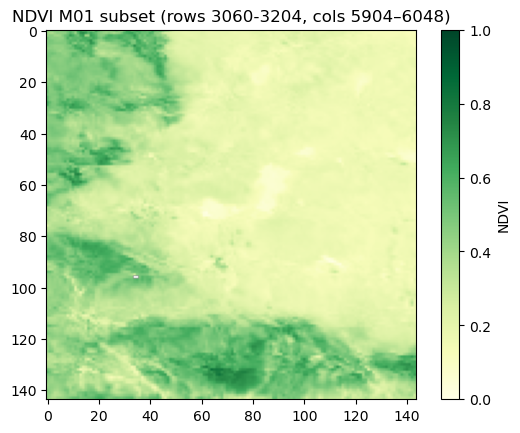

In [91]:

s3_path = "s3://nsidc-cumulus-prod-protected/SMAP-ANC/SMAP_L1_L3_ANC_STATIC/1/2015/01/14/NDVI_M01_001_002.int16"

subset = read_ndvi_int16_window(
    s3_path, ny, nx,
    row_start=min(rows), row_end=max(rows),
    col_start=min(cols), col_end=max(cols),
    scale=1/10000.0, nodata=-9999,  # adjust nodata to your product
    fs=fs,
    anon=False  # if you’re using Earthdata/NSIDC credentials
)

import matplotlib.pyplot as plt
plt.imshow(subset, cmap="YlGn", vmin=0, vmax=1)
plt.colorbar(label="NDVI")
plt.title(f"NDVI M01 subset (rows {rows[0]}-{rows[1]}, cols {cols[0]}–{cols[1]})")
plt.show()


## 4) Process each NDVI file → scale → reproject → write

In [92]:

# Your window indices (used when reading the subset)
# row_start, row_end, col_start, col_end = ...

# --- 2) Build the affine for the *window* you read ---
# from_origin expects (upper-left-x, upper-left-y, xres, yres)
# Note: in north-up rasters, the y pixel size is positive here, but from_origin
# creates a transform with negative y scale internally (expected behavior).

ulx_window = ulx + cols[0] * pixel_size
uly_window = uly - rows[0] * pixel_size
src_transform = from_origin(ulx_window, uly_window, pixel_size, pixel_size)

print("Source window shape:", subset.shape)
print("Source window UL (m):", ulx_window, uly_window)
print("Source CRS:", src_crs)

# --- 3) Reproject to template grid ---
dst = np.full((dst_height, dst_width), np.nan, dtype="float32")

reproject(
    source=subset,
    destination=dst,
    src_transform=src_transform,
    src_crs=src_crs,
    dst_transform=dst_transform,
    dst_crs=dst_crs,
    src_nodata=-9999,
    dst_nodata=np.nan,                     # keeps NaN through reprojection
    resampling=Resampling.bilinear,        # NDVI → bilinear is typical
)

# --- 4) Write aligned GeoTIFF (same footprint as template) ---
out_dir = Path("../data/outputs/aligned/ndvi")
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "ndvi_window_utm200m.tif"

with rasterio.open(template_path) as tmp:
    profile = tmp.profile
profile.update(
    dtype="float32",
    count=1,
    compress="deflate",
    tiled=True,
    nodata=np.nan,                         # okay for float32 GeoTIFF
)
with rasterio.open(out_path, "w", **profile) as ds:
    ds.write(dst, 1)

print("✅ Wrote:", out_path)


Source window shape: (144, 144)
Source window UL (m): -11458216.840000002 4251786.83
Source CRS: EPSG:6933
✅ Wrote: ../data/outputs/aligned/ndvi/ndvi_window_utm200m.tif


CRS: EPSG:32611
Bounds (m): BoundingBox(left=363600.0, bottom=3789200.0, right=457400.0, top=3913800.0)
Shape: (623, 469)
Value range: 0.013 – 0.821


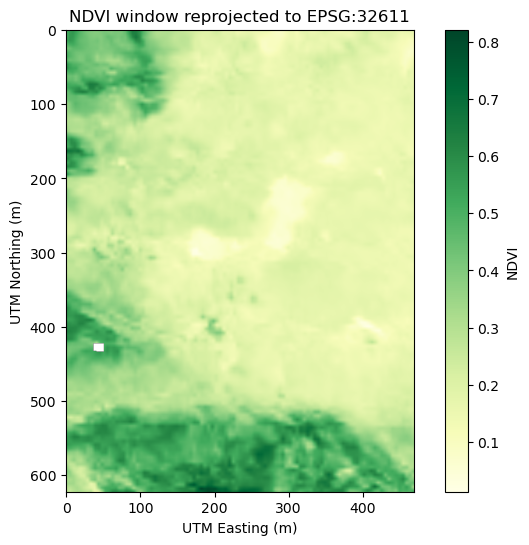

In [93]:

with rasterio.open(out_path) as ds:
    arr = ds.read(1, masked=True)
    crs = ds.crs
    bounds = ds.bounds
    transform = ds.transform

print(f"CRS: {crs}")
print(f"Bounds (m): {bounds}")
print(f"Shape: {arr.shape}")
print(f"Value range: {np.nanmin(arr):.3f} – {np.nanmax(arr):.3f}")

plt.figure(figsize=(8, 6))
im = plt.imshow(arr, cmap="YlGn", origin="upper")
plt.colorbar(im, label="NDVI")
plt.title(f"NDVI window reprojected to {crs.to_string()}")
plt.xlabel("UTM Easting (m)")
plt.ylabel("UTM Northing (m)")
plt.show()


---
### Notes
- This scaffold assumes **planar EASE-Grid 2.0** with affine derived from `ulx`, `uly`, `pixel_size`.
- If you want an automatic affine derivation using `ease-lonlat`, I can add a helper that samples (row, col)→(lon,lat) at corners and solves for `from_origin` parameters.
- Ensure the `endianness` matches your binary (many products are little-endian).
- If you see the image flipped vertically, set the sign of `pixel_size` for Y to negative (GDAL north-up uses negative y pixel size). The `from_origin` helper handles this for you.
